# 1 Imports y configuraciones

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.4.0
ipykernel        : 6.15.1
ipywidgets       : 7.7.1
jupyter_client   : 7.3.4
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.6.6
nbconvert        : 6.5.0
nbformat         : 5.4.0
notebook         : 6.4.12
qtconsole        : 5.3.1
traitlets        : 5.3.0


In [49]:
import datetime
from pathlib import Path

import airportsdata as airdata
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from folium.plugins import MarkerCluster

sns.set()

# 2. Exploratory Data Analysis
## 2.1 Leer dataset

In [2]:
data = pd.read_csv(Path().joinpath('data', 'dataset_SCL.csv'))

C:\Users\Admin\AppData\Local\Temp\ipykernel_12564\2557340355.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(Path().joinpath('data', 'dataset_SCL.csv'))


## 2.2 Chequear y corregir data types

De acuerdo a la documentación del desafío, las columnas son las siguientes:

- Fecha-I : Fecha y hora programada del vuelo. &rarr; **datetime**
- Vlo-I : Número de vuelo programado. &rarr; **integer**
- Ori-I : Código de ciudad de origen programado. &rarr; **string**
- Des-I : Código de ciudad de destino programado. &rarr; **string**
- Emp-I : Código aerolínea de vuelo programado. &rarr; **string**
- Fecha-O : Fecha y hora de operación del vuelo. &rarr; **datetime**
- Vlo-O : Número de vuelo de operación del vuelo. &rarr; **integer**
- Ori-O : Código de ciudad de origen de operación. &rarr; **string**
- Des-O : Código de ciudad de destino de operación. &rarr; **string**
- Emp-O : Código aerolínea de vuelo operado. &rarr; **string**
- DIA : Día del mes de operación del vuelo. &rarr; **integer**
- MES : Número de mes de operación del vuelo. &rarr; **integer**
- AÑO : Año de operación del vuelo. &rarr; **integer**
- DIANOM : Día de la semana de operación del vuelo. &rarr; **string**
- TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional. &rarr; **string (binary)**
- OPERA : Nombre de aerolínea que opera. &rarr; **string**
- SIGLAORI : Nombre ciudad origen. &rarr; **string**
- SIGLADES : Nombre ciudad destino. &rarr; **string**

In [3]:
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB
None


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


Al parecer hay columnas con más de un tipo de dato, veamos cuales.

*Obs: Los códigos de aeropuerto están en formato ICAO.*

In [4]:
for i in data.columns:
    print(i, data[i].apply(lambda x: type(x).__name__).value_counts().to_dict())

Fecha-I {'str': 68206}
Vlo-I {'str': 65536, 'int': 2670}
Ori-I {'str': 68206}
Des-I {'str': 68206}
Emp-I {'str': 68206}
Fecha-O {'str': 68206}
Vlo-O {'str': 65535, 'float': 2671}
Ori-O {'str': 68206}
Des-O {'str': 68206}
Emp-O {'str': 68206}
DIA {'int': 68206}
MES {'int': 68206}
AÑO {'int': 68206}
DIANOM {'str': 68206}
TIPOVUELO {'str': 68206}
OPERA {'str': 68206}
SIGLAORI {'str': 68206}
SIGLADES {'str': 68206}


Las columnas 'Vlo-I' y 'Vlo-O' tienen mezclados int/float y str, por lo que se transformarán a int solamente ya que representan números de vuelo. Adicionalmente, las columnas de fecha son strings pero deberían convertirse a datetime.

In [5]:
data = data.convert_dtypes()  # Cast object to str where possible
data[['Fecha-I', 'Fecha-O']] = data[['Fecha-I', 'Fecha-O']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

Como los valores que se convertirán a int vienen como str, no necesariamente se podrán convertir por lo que hay que chequear que sean correctos

In [6]:
# Check which rows can't be cast from str to number
not_numeric_1 = data['Vlo-I'].apply(pd.to_numeric, errors='coerce').isna()
not_numeric_2 = data['Vlo-O'].apply(pd.to_numeric, errors='coerce').isna()
not_numeric = (not_numeric_1 | not_numeric_2)
data.loc[not_numeric]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71R,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71R,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201R,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71R,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43R,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989P,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401A,SCEL,LFPG,AFR,26,5,2017,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401B,SCEL,LFPG,AFR,28,5,2017,Domingo,I,Air France,Santiago,Paris
24304,2017-05-11 10:00:00,802,SCEL,SPJC,SKU,2017-05-11 10:36:00,802R,SCEL,SPJC,SKU,11,5,2017,Jueves,I,Sky Airline,Santiago,Lima


Vemos que los casos que no pueden ser convertidos a str son porque tienen una letra al final, esto podría ser algún código de la aerolínea o simplemente un error a la hora de ingresar el dato, supondré que es esto último y que el número es el correcto al quitar la letra del final.

Además vemos que hay una fila con un Nan.

In [7]:
data.loc[not_numeric_1, 'Vlo-I'] = data.loc[not_numeric_1, 'Vlo-I'].apply(lambda x: x[:-1] if isinstance(x, str) and not x[-1].isnumeric() else x)
data.loc[not_numeric_2, 'Vlo-O'] = data.loc[not_numeric_2, 'Vlo-O'].apply(lambda x: x[:-1] if isinstance(x, str) and not x[-1].isnumeric() else x)
data.loc[not_numeric]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401,SCEL,LFPG,AFR,26,5,2017,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401,SCEL,LFPG,AFR,28,5,2017,Domingo,I,Air France,Santiago,Paris
24304,2017-05-11 10:00:00,802,SCEL,SPJC,SKU,2017-05-11 10:36:00,802,SCEL,SPJC,SKU,11,5,2017,Jueves,I,Sky Airline,Santiago,Lima


In [8]:
# Check Nan values in the whole dataset
print(data.isna().sum())
data = data.dropna()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64


El Nan que vimos antes es el único en todo el dataset, por lo que se elimina esa fila.

Finalmente, se puede convertir los strings a int.

In [9]:
data['Vlo-I'] = data['Vlo-I'].astype(int)  # Cast str to int
data['Vlo-O'] = pd.to_numeric(data['Vlo-O'])  # Cast str to float first
data['Vlo-O'] = data['Vlo-O'].astype(int)  # Cast float to int
data.dtypes

Fecha-I      datetime64[ns]
Vlo-I                 int32
Ori-I                string
Des-I                string
Emp-I                string
Fecha-O      datetime64[ns]
Vlo-O                 int32
Ori-O                string
Des-O                string
Emp-O                string
DIA                   Int64
MES                   Int64
AÑO                   Int64
DIANOM               string
TIPOVUELO            string
OPERA                string
SIGLAORI             string
SIGLADES             string
dtype: object

## 2.3 Consistencia de los datos por columna
### 2.3.1 DIA, DIANOM, MES, AÑO, OPERA, SIGLAORI, SIGLADES

In [10]:
print(f"Días del mes: {np.sort(data['DIA'].unique())}\n")
print(f"Días de la semana: {np.sort(data['DIANOM'].unique())}\n")
print(f"Meses: {np.sort(data['MES'].unique())}\n")
print(f"Años: {np.sort(data['AÑO'].unique())}\n")
print(f"Aerolíneas: {np.sort(data['OPERA'].unique())}\n")
print(f"Ciudades de origen: {np.sort(data['SIGLAORI'].unique())}\n")
print(f"Ciudades destino: {np.sort(data['SIGLADES'].unique())}\n")

Días del mes: [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31]

Días de la semana: ['Domingo' 'Jueves' 'Lunes' 'Martes' 'Miercoles' 'Sabado' 'Viernes']

Meses: [1 2 3 4 5 6 7 8 9 10 11 12]

Años: [2017 2018]

Aerolíneas: ['Aerolineas Argentinas' 'Aeromexico' 'Air Canada' 'Air France' 'Alitalia'
 'American Airlines' 'Austral' 'Avianca' 'British Airways' 'Copa Air'
 'Delta Air' 'Gol Trans' 'Grupo LATAM' 'Iberia' 'JetSmart SPA' 'K.L.M.'
 'Lacsa' 'Latin American Wings' 'Oceanair Linhas Aereas'
 'Plus Ultra Lineas Aereas' 'Qantas Airways' 'Sky Airline'
 'United Airlines']

Ciudades de origen: ['Santiago']

Ciudades destino: ['Antofagasta' 'Arica' 'Asuncion' 'Atlanta' 'Auckland N.Z.' 'Balmaceda'
 'Bariloche' 'Bogota' 'Buenos Aires' 'Calama' 'Cancun' 'Castro (Chiloe)'
 'Cataratas Iguacu' 'Ciudad de Mexico' 'Ciudad de Panama' 'Cochabamba'
 'Concepcion' 'Copiapo' 'Cordoba' 'Curitiba, Bra.' 'Dallas'
 'Florianapolis' 'Guayaquil' 'Houston' 'Iquique' 'Isla de P

- Los días del mes, días de la semana y meses tienen todos los valores posibles. Además vemos que los datos son de 2017 y 2018.
- Las aerolíneas están correctas y no se dan repeticiones erróneas (por typos por ejemplo).
- Se ve que la única ciudad de origen es Santiago mientras que los destinos son diferentes ciudades en América, Europa y Australia. Además no se dan repeticiones erróneas.

Adicionalmente, uno esperaría que los datos de programación en general sean iguales a los de operación, excepto el tiempo que es lo que se busca predecir, por lo que se verán esas comparaciones a continuación.

### 2.3.2 Ciudad de origen programada vs operacional

In [11]:
(data['Ori-I'] == data['Ori-O']).value_counts()/len(data) * 100

True    100.0
dtype: Float64

Todos los códigos de origen coinciden en programación y operación.

### 2.3.3 Ciudad de destino programada vs operacional

In [12]:
(data['Des-I'] == data['Des-O']).value_counts()/len(data) * 100

True     99.958947
False     0.041053
dtype: Float64

En unos pocos casos (0.04%) se tiene que el código de destino es diferente entre programación y operación, veamos los códigos para las ciudades que tienen esta diferencia y la cantidad de códigos coincidentes y no coincidentes.

In [13]:
# Search for cities which have mismatch in Des-I and Des-O
des_mismatch = data.loc[data['Des-I'] != data['Des-O'], 'SIGLADES'].unique().tolist()
# Count unique ocurrences of (Des-I, Des-O) for the mismatching cities
df_mismatch = data.loc[data['SIGLADES'].isin(des_mismatch)].groupby(['Des-I', 'Des-O','SIGLADES']).size().reset_index(name='count').sort_values(by=['SIGLADES','count'], ascending=[True, False])
df_mismatch['des_match'] = df_mismatch['Des-I'] == df_mismatch['Des-O']
df_mismatch

,Des-I,Des-O,SIGLADES,count,des_match
6,SAEZ,SAEZ,Buenos Aires,3237,True
3,SABE,SABE,Buenos Aires,3090,True
4,SABE,SAEZ,Buenos Aires,4,False
5,SAEZ,SABE,Buenos Aires,3,False
22,SEGU,SABE,Buenos Aires,1,False
12,SCCF,SCCF,Calama,5145,True
15,SCFA,SCCF,Calama,1,False
7,SARI,SBFI,Cataratas Iguacu,1,False
8,SBFI,SBFI,Cataratas Iguacu,1,True
25,YMML,YMML,Melbourne,38,True


Una razón por la que puede haber incongruencia es en el caso que hayan datos incorrectos, o sea códigos que no corresponden a ningún aeropuerto así que veamos si es el caso.

In [14]:
airport_codes = airdata.load()  # Library with airport ICAO codes


def get_data_by_icao(x: str, key: str, codes: dict):
    """
    Get airport/airline data based on its ICAO code.
    :param x: ICAO code to be found.
    :param key: Field of the airport to get (e.g. name, latitude, city, etc).
    :param codes: Lookup table (dict) with ICAO codes as keys and a dictionary with that code's metadata as values
    (e.g. airline name, airport name or any field contained in the codes dict).
    :return: Returns the desired key for specified ICAO code, if the code isn't in codes dict or the field doesn't exist
    for the specific code it returns None. The type of the output can be whatever is inside the dict (str, float, int, etc).
    """
    try:
        icao_data = codes[x]
        try:
            return icao_data[key]
        except KeyError:
            print(f'{key} is not a valid field.')
            return None
    except KeyError:
        return None


    
data['city_i'] = data['Des-I'].apply(get_data_by_icao, key='city', codes=airport_codes)
data['name_i'] = data['Des-I'].apply(get_data_by_icao, key='name', codes=airport_codes)
data['city_o'] = data['Des-O'].apply(get_data_by_icao, key='city', codes=airport_codes)    
data['name_o'] = data['Des-O'].apply(get_data_by_icao, key='name', codes=airport_codes)
data.loc[(data['name_i'].isna()) | (data['name_o'].isna())].drop_duplicates(subset=['name_i', 'city_i', 'Des-I', 'name_o', 'city_o', 'Des-O', 'SIGLADES'])

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,city_i,name_i,city_o,name_o
1397,2017-01-17 19:20:00,25,SCEL,SCTE,SKU,2017-01-17 19:46:00,25,SCEL,SCQP,SKU,...,2017,Martes,N,Sky Airline,Santiago,Temuco,Puerto Montt,El Tepual Airport,None,None
1463,2017-01-01 08:30:00,51,SCEL,SCQP,SKU,2017-01-01 08:26:00,51,SCEL,SCQP,SKU,...,2017,Domingo,N,Sky Airline,Santiago,Temuco,None,None,None,None
7520,2017-02-27 06:40:00,71,SCEL,SCIE,SKU,2017-02-27 09:07:00,71,SCEL,SCQP,SKU,...,2017,Lunes,N,Sky Airline,Santiago,Temuco,Concepcion,Carriel Sur Airport,None,None
55144,2017-10-06 00:55:00,1260,SCEL,SEQU,LAN,2017-10-06 02:15:00,1260,SCEL,SEQM,LAN,...,2017,Viernes,I,Grupo LATAM,Santiago,Quito,None,None,Quito,Nuevo Aeropuerto Internacional Mariscal Sucre


Los únicos códigos que no corresponden son los de Temuco (SCQP) y Quito (SEQU), pero al investigar corroboré que estos códigos sí corresponden a esas ciudades ([ICAO Temuco](https://www.codigosinternacionales.com/icao/codigo-icao-del-aeropuerto-de-freire-temuco/), [ICAO Quito](https://airportcodes.aero/uio/quito-airport-code)), es un problema de la librería que no está actualizada.

Por lo tanto los cambios en código de destino no se deben a códigos erróneos.

Por otro lado, la razón por la que hay códigos que cambian podría deberse a cambios en ciudades con más de un aeropuerto, osea el mismo vuelo hacia la misma ciudad que aterriza en un aeropuerto distinto al planificado.

Además, se puede tener el caso de que el destino cambia como en el ejemplo de arriba se tiene un vuelo programado hacia Pto. Montt, pero en la operación fue a Temuco, lo cual puede deberse a problemas ambientales, cambios de vuelo, etc.

In [15]:
# Add missing ICAO codes to library dict
airport_codes_fix = airport_codes.copy()
airport_codes_fix['SEQU'] = {'icao': 'SEQU',
              'name': 'Mariscal Sucre International Airport',
              'city': 'Quito',
                        'lat': -0.12,
                        'lon': -78.3}
airport_codes_fix['SCQP'] = {'icao': 'SCQP',
              'name': 'Aeropuerto Internacional La Araucanía',
              'city': 'Temuco',
                        'lat': -38.9,
                        'lon': -72.6}

In [16]:
data['city_i'] = data['Des-I'].apply(get_data_by_icao, key='city', codes=airport_codes_fix)
data['name_i'] = data['Des-I'].apply(get_data_by_icao, key='name', codes=airport_codes_fix)
data['city_o'] = data['Des-O'].apply(get_data_by_icao, key='city', codes=airport_codes_fix)    
data['name_o'] = data['Des-O'].apply(get_data_by_icao, key='name', codes=airport_codes_fix)

# This is the same code as before but now having the new name and city columns from the ICAO code
des_mismatch = data.loc[data['Des-I'] != data['Des-O'], 'SIGLADES'].unique().tolist()
df_mismatch = data.loc[data['SIGLADES'].isin(des_mismatch)].groupby(['name_i', 'city_i', 'name_o', 'city_o', 'SIGLADES']).size().reset_index(name='count').sort_values(by=['SIGLADES','count'], ascending=[True, False])
cond = (df_mismatch['name_i'] != df_mismatch['name_o']) | (df_mismatch['city_i'] != df_mismatch['city_o'])
df_mismatch.loc[cond]

,name_i,city_i,name_o,city_o,SIGLADES,count
16,Jorge Newbery Airpark,Buenos Aires,Ministro Pistarini International Airport,Ezeiza,Buenos Aires,4
20,Ministro Pistarini International Airport,Ezeiza,Jorge Newbery Airpark,Buenos Aires,Buenos Aires,3
25,Simon Bolivar International Airport,Guayaquil,Jorge Newbery Airpark,Buenos Aires,Buenos Aires,1
6,Cerro Moreno Airport,Antofagasta,El Loa Airport,Calama,Calama,1
4,Cataratas Del Iguazu International Airport,Puerto Iguazu,Cataratas International Airport,Foz Do Iguacu,Cataratas Iguacu,1
26,Sydney Kingsford Smith International Airport,Sydney,Melbourne International Airport,Melbourne,Melbourne,1
14,John F Kennedy International Airport,New York,Miami International Airport,Miami,Miami,1
1,Balmaceda Airport,Balmaceda,El Tepual Airport,Puerto Montt,Puerto Montt,4
3,Carriel Sur Airport,Concepcion,El Tepual Airport,Puerto Montt,Puerto Montt,1
23,Pdte. Carlos Ibanez del Campo Airport,Punta Arenas,El Tepual Airport,Puerto Montt,Puerto Montt,1


Efectivamente ocurre que en algunos casos se cambia de aeropuerto para una misma ciudad y en otros casos se cambia de ciudad. Además vemos que la columna 'SIGLADES' corresponde a la ciudad de operación, no la programada, por lo que sería una columna redundante.

Dado que no son demasiados datos con esta incongruencia (28 filas, 0.04%), podrían eliminarse sin problema. Otra opción sería agregar variables categóricas que indiquen si la fila tuvo cambio de aeropuerto dentro de la misma ciudad o cambio de destino, aunque en este último caso no tendría mucho sentido medir el atraso si el destino es distinto, pues los tiempos de vuelo también lo serán.

### 2.3.4 Número de vuelo programado vs operacional

In [17]:
(data['Vlo-I'] == data['Vlo-O']).value_counts()/len(data) * 100

True     99.850451
False     0.149549
dtype: float64

0.1% de los datos tienen número de vuelo no coincidente entre programación y operación. Esto podría ser un error en los datos o bien un cambio en la programación. Es decir otro vuelo con el mismo origen y destino suplió la demanda del vuelo programado, esto podría implicar retrasos considerables con respecto a lo programado.

In [18]:
data.loc[data['Vlo-I'] != data['Vlo-O']]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,city_i,name_i,city_o,name_o
6018,2017-01-05 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-05 09:36:00,1001,SCEL,SAEZ,LAN,...,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport
6020,2017-01-07 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-07 06:59:00,1001,SCEL,SAEZ,LAN,...,2017,Sabado,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport
6022,2017-01-12 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-12 08:05:00,1003,SCEL,SAEZ,LAN,...,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport
6023,2017-01-13 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-13 07:06:00,1001,SCEL,SAEZ,LAN,...,2017,Viernes,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport
6025,2017-01-19 10:50:00,4501,SCEL,SAEZ,LAN,2017-01-19 10:56:00,1001,SCEL,SAEZ,LAN,...,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56569,2017-11-13 16:00:00,302,SCEL,SPJC,PUE,2017-11-13 16:00:00,304,SCEL,SPJC,PUE,...,2017,Lunes,I,Plus Ultra Lineas Aereas,Santiago,Lima,Lima,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport
60565,2017-11-05 22:10:00,530,SCEL,SPJC,LAN,2017-11-05 22:24:00,534,SCEL,SPJC,LAN,...,2017,Domingo,I,Grupo LATAM,Santiago,Lima,Lima,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport
61354,2017-11-09 11:20:00,7811,SCEL,SAEZ,LAN,2017-11-09 12:23:00,1103,SCEL,SAEZ,LAN,...,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport
62175,2017-12-20 19:25:00,2287,SCEL,SAEZ,ARG,2017-12-20 20:17:00,1287,SCEL,SAEZ,AUT,...,2017,Miercoles,I,Aerolineas Argentinas,Santiago,Buenos Aires,Ezeiza,Ministro Pistarini International Airport,Ezeiza,Ministro Pistarini International Airport


No se ve que haya una regularidad cuando los códigos de vuelo no coinciden. Además los códigos se repiten entre filas, en un principio supuse que el código de vuelo representa un ID del vuelo (o sea único por vuelo) pero al parecer no es así ya que se repiten códigos para días y horas de vuelo diferentes.

In [19]:
print(data[['Vlo-I']].value_counts().describe())  # Count of unique programmed flight numbers 
print(data[['Vlo-O']].value_counts().describe())  # Count of unique operational flight numbers 

count    581.000000
mean     117.392427
std      141.965941
min        1.000000
25%        3.000000
50%       43.000000
75%      220.000000
max      686.000000
dtype: float64
count    595.000000
mean     114.630252
std      141.281512
min        1.000000
25%        3.000000
50%       39.000000
75%      213.500000
max      686.000000
dtype: float64


- En todo el dataset, menos del 25% de códigos de vuelo tanto programados como de operación son únicos, es decir la mayoría se repiten, por lo que esta columna no representaría un ID (único) de vuelo.
- Vemos que la cantidad de números de vuelo no coincidentes es baja (102 filas, 0.14%), por lo que sin más contexto de qué significa esta columna, optaría por eliminarla. Al igual que con las columnas de destino, también podría agregarse una variable categórica que indique cambio de vuelo para que se incorpore como una feature al modelo, ya que podría ser que estos casos tengan un mayor atraso.

### 2.3.5 Aerolínea programada vs operacional

In [20]:
(data['Emp-I'] == data['Emp-O']).value_counts()/len(data)

True     0.726296
False    0.273704
dtype: Float64

El 27% de los datos tuvo un cambio en la aerolínea entre lo programado y operacional.

In [21]:
data.loc[data['Emp-I'] != data['Emp-O'], ['Emp-I', 'Emp-O', 'OPERA']]

,Emp-I,Emp-O,OPERA
345,AUT,ARG,Austral
814,AVA,LRC,Avianca
815,AVA,LRC,Avianca
816,AVA,LRC,Avianca
817,AVA,LRC,Avianca
...,...,...,...
67877,LAW,JMR,Latin American Wings
67878,LAW,JMR,Latin American Wings
67879,LAW,JMR,Latin American Wings
67880,LAW,JMR,Latin American Wings


- Vemos que 'OPERA' coincide con con el código de aerolínea programado, así que 'Emp-I' y 'OPERA' son redundantes.
- Similar a los casos anteriores, estos cambios probablemente se deben a disponibilidad de vuelos.

In [22]:
# Search for airlines which have mismatch in Emp-I and Emp-O
des_mismatch = data.loc[data['Emp-I'] != data['Emp-O'], 'OPERA'].unique().tolist()
# Count unique ocurrences of (Des-I, Des-O) for the mismatching cities
df_mismatch = data.loc[data['OPERA'].isin(des_mismatch)].groupby(['Emp-I', 'Emp-O','OPERA']).size().reset_index(name='count').sort_values(by=['OPERA','count'], ascending=[True, False])
df_mismatch['des_match'] = df_mismatch['Emp-I'] == df_mismatch['Emp-O']
df_mismatch

,Emp-I,Emp-O,OPERA,count,des_match
0,ARG,ARG,Aerolineas Argentinas,1944,True
1,ARG,AUT,Aerolineas Argentinas,5,False
3,AUT,AUT,Austral,72,True
2,AUT,ARG,Austral,2,False
4,AVA,AVA,Avianca,885,True
5,AVA,LRC,Avianca,265,False
6,AVA,TPU,Avianca,2,False
10,LAN,LAN,Grupo LATAM,20988,True
13,LAN,LXP,Grupo LATAM,14549,False
23,TAM,TAM,Grupo LATAM,3046,True


Para ver si estos códigos son válidos me basaré en [esta tabla](https://en.wikipedia.org/wiki/List_of_airline_codes) que descargué de wikipedia.

In [23]:
airline_codes = pd.read_csv(Path().joinpath('data', 'airline_icao_data.csv'))
# Some airlines appear more than once so duplicates ar dropped
airline_codes = airline_codes.loc[(~airline_codes['ICAO'].isna())].drop_duplicates(subset=['ICAO'])
# Convert to dict with ICAO as key and row as dict with key-value pairs
airline_codes = airline_codes.set_index('ICAO', drop=False).to_dict('index')

data['airline_i'] = data['Emp-I'].apply(get_data_by_icao, key='Airline', codes=airline_codes)
data['airline_o'] = data['Emp-O'].apply(get_data_by_icao, key='Airline', codes=airline_codes)    
data.loc[(data['airline_i'].isna()) | (data['airline_o'].isna())].drop_duplicates(subset=['airline_i', 'Emp-I', 'airline_o', 'Emp-O', 'OPERA'])

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,city_i,name_i,city_o,name_o,airline_i,airline_o
845,2017-01-01 13:35:00,28,SCEL,YSSY,QFU,2017-01-01 14:56:00,28,SCEL,YSSY,QFA,...,I,Qantas Airways,Santiago,Sydney,Sydney,Sydney Kingsford Smith International Airport,Sydney,Sydney Kingsford Smith International Airport,None,Qantas
6058,2017-01-01 11:00:00,200,SCEL,SPJC,LAW,2017-01-01 11:07:00,200,SCEL,SPJC,48O,...,I,Latin American Wings,Santiago,Lima,Lima,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Link Airways of Australia,None
6067,2017-01-18 11:00:00,200,SCEL,SPJC,LAW,2017-01-18 11:06:00,200,SCEL,SPJC,56R,...,I,Latin American Wings,Santiago,Lima,Lima,Jorge Chavez International Airport,Lima,Jorge Chavez International Airport,Link Airways of Australia,None


- El código QFU no está asociado a ninguna aerolína, sin embargo siempre está asociado a QFA en operación que corresponde a la aerolínea australiana Qantas, por lo que supondría que es un error o algún código antiguo y que lo programado y operacional sí coinciden.
- La aerolínea Latin American Wings tiene casos (26 filas) con códigos de operación que no corresponden a nada (48O y 56R).  Supondré que estos vuelos sí existieron bajo esa aerolínea por lo que podría reemplazar con el código correcto.
- Además, el código LAW se mapea a Link Airways of Australia según los datos de códigos de aerolíneas. Esto debe ser porque Latin American Wings fue una aerolínea chilena que duró solo dos años (2016-2018) así que seguramente no estará en repositorios de códigos ICAO.

In [24]:
# Destino y cantidad de vuelos cuando la aerolínea es 'LAW'
data.loc[(data['Emp-I'] == 'LAW') | (data['Emp-O'] == 'LAW')]['SIGLADES'].value_counts()

Lima            810
Concepcion      349
Mendoza         218
Puerto Montt    127
Antofagasta      69
Name: SIGLADES, dtype: Int64

Como todos los vuelos de código 'LAW' son de Latin American Wings (ya que no hay destinos a Australia con ese código) se puede ignorar que 'LAW' oficialmente corresponde a Link Airways of Australia aunque esto podría generar problemas en un dataset más grande donde se encuentren datos de ambas aerolíneas, en ese caso habría que cambiar alguna de las dos ('LAW2' para Latin American Wings por ejemplo).

In [25]:
# Cast 'LAW' airline name as Latin American Wings
data.loc[(data['Emp-I'] == 'LAW'), 'airline_i'] = 'Latin American Wings' 
data.loc[(data['Emp-O'] == 'LAW'), 'airline_o'] = 'Latin American Wings'

In [26]:
des_mismatch = data.loc[data['Emp-I'] != data['Emp-O'], 'OPERA'].unique().tolist()
df_mismatch = data.loc[data['OPERA'].isin(des_mismatch)].groupby(['Emp-I', 'airline_i', 'Emp-O', 'airline_o', 'OPERA']).size().reset_index(name='count').sort_values(by=['OPERA','count'], ascending=[True, False])
cond = (df_mismatch['airline_i'] != df_mismatch['airline_o'])
df_mismatch.loc[cond]

,Emp-I,airline_i,Emp-O,airline_o,OPERA,count
1,ARG,Aerolíneas Argentinas,AUT,Austral Líneas Aéreas,Aerolineas Argentinas,5
2,AUT,Austral Líneas Aéreas,ARG,Aerolíneas Argentinas,Austral,2
5,AVA,Avianca,LRC,LACSA,Avianca,265
6,AVA,Avianca,TPU,Trans American Airlines (Trans Am),Avianca,2
13,LAN,LATAM Chile,LXP,LATAM Express,Grupo LATAM,14549
12,LAN,LATAM Chile,LPE,LATAM Peru,Grupo LATAM,1210
9,LAN,LATAM Chile,DSM,LATAM Argentina,Grupo LATAM,491
11,LAN,LATAM Chile,LNE,Aerolane,Grupo LATAM,373
19,TAM,LATAM Brasil,LAP,LATAM Paraguay,Grupo LATAM,3
15,LAW,Latin American Wings,JMR,Alexandair,Latin American Wings,1547


- En el caso de LATAM existen varios servicios regionales (Perú, Argentina, etc) y también está el servicio express, lo que explica el cambio en código pero con la misma aerolínea.
- Para Aerolíneas Argentinas y Avianca el cambio se debe a que la misma aerolínea tiene un nombre antiguo o alternativo (Austral, LACSA), por lo que también podría considerarse que si bien cambia el código la aerolínea se mantiene.

El caso de Latin American Wings lo detallaré más a continuación.

In [27]:
# Find rows where LAW was programmed but JMR was operated
data.loc[(data['airline_i'] == 'Latin American Wings') & (data['airline_o'] == 'Alexandair'), ['city_i', 'Emp-I', 'city_o', 'Emp-O', 'OPERA']].value_counts()

city_i        Emp-I  city_o        Emp-O  OPERA               
Lima          LAW    Lima          JMR    Latin American Wings    784
Concepcion    LAW    Concepcion    JMR    Latin American Wings    349
Mendoza       LAW    Mendoza       JMR    Latin American Wings    218
Puerto Montt  LAW    Puerto Montt  JMR    Latin American Wings    126
Antofagasta   LAW    Antofagasta   JMR    Latin American Wings     69
Concepcion    LAW    Puerto Montt  JMR    Latin American Wings      1
dtype: int64

In [28]:
airline_codes['JMR']

{'IATA': nan,
 'ICAO': 'JMR',
 'Airline': 'Alexandair',
 'Call sign': 'ALEXANDAIR',
 'Country/Region': 'Canada',
 'Comments': nan}

En muchos casos se tiene que la empresa programada era Latin American Wings pero la de operación es "JMR" que según la tabla que encontré en wikipedia es una aerolínea canadiense pero al buscarla solo hay información acerca de una desaparecida línea griega con ese nombre, por lo que supondré que es un error y esos vuelos efectivamente se realizaron a través de LAW.

Dado que todas las incongruencias pueden explicarse (haciendo supuestos) bastaría con usar la columna 'OPERA' ya que las columnas 'Des-I' y 'Des-O' tendrían información redundante. El único caso donde habría que corregir la data es con Aerolíneas Argentinas y Austral que serían lo mismo y se usará el primer nombre.

In [29]:
data.loc[data['OPERA'] == 'Austral', 'OPERA'] = 'Aerolíneas Argentinas'

## 2.4 Distribución de los datos
### 2.4.1 Fechas - Datos por mes y año

          count
2017-Jan   6105
2017-Feb   5561
2017-Mar   5482
2017-Apr   5020
2017-May   5240
2017-Jun   4981
2017-Jul   5992
2017-Aug   5744
2017-Sep   5610
2017-Oct   6032
2017-Nov   6080
2017-Dec   6356
2018-Jan      2


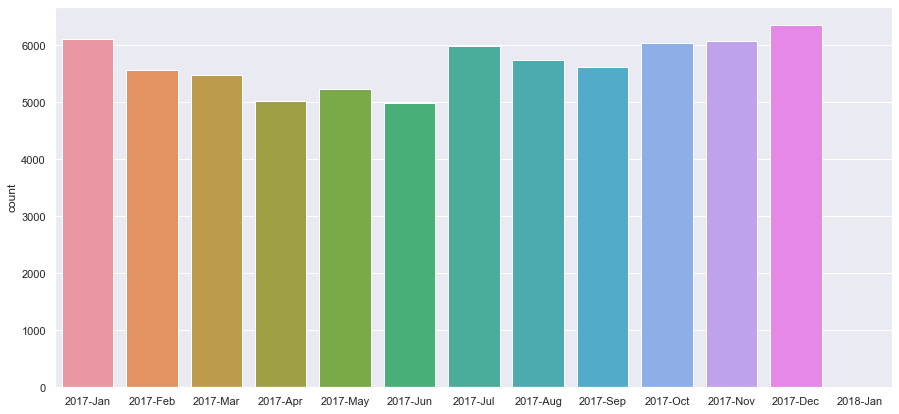

In [30]:
ym = data[['Fecha-O']].groupby([data['Fecha-O'].dt.year.rename('year'), data['Fecha-O'].dt.month.rename('month')]).agg({'count'})['Fecha-O']
ym.index = [pd.to_datetime(f'{i[0]}-{i[1]}', format='%Y-%m').strftime('%Y-%b') for i in ym.index]
print(ym)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(x=ym.index, y=ym['count'], ax=ax)

- Las fechas se encuentran casi exclusivamente en 2017, sólo hay 2 filas del 2018. Además, cada mes de 2017 tiene una cantidad de datos similar (~5000).
- Los peaks de vuelos se encuentran en diciembre y enero.

### 2.4.2 Días del mes

20    2290
27    2286
12    2284
10    2283
6     2275
22    2272
13    2272
3     2271
16    2268
26    2267
21    2267
7     2264
23    2260
5     2241
15    2239
19    2237
11    2237
24    2232
28    2232
17    2228
9     2227
2     2223
14    2221
4     2215
8     2213
1     2208
25    2179
18    2160
29    2044
30    2020
31    1290
Name: DIA, dtype: Int64


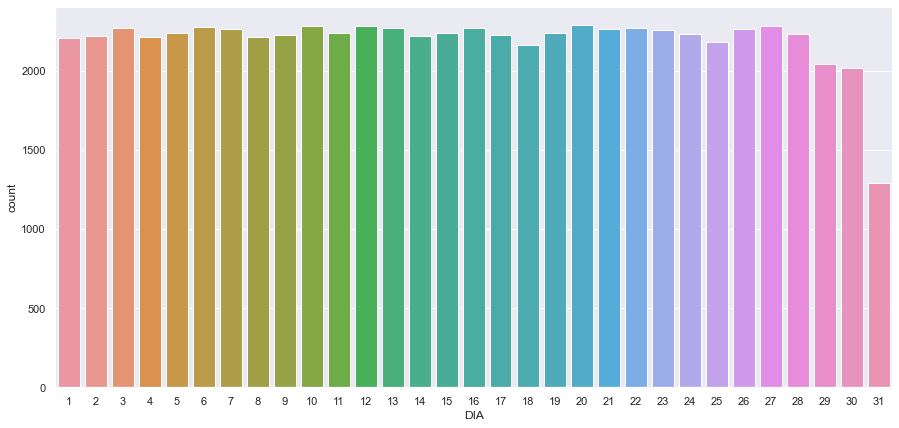

In [31]:
print(data['DIA'].value_counts())
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='DIA', ax=ax)

Se ve que la distribución por día del mes es similar, los días 29, 30 y 31 tienen menos cantidad de datos, pero esto se debe a que en un año hay menos meses que contienen esos días. Normalizando por la cantidad de días se puede ver la frecuencia real.

          count
DIA            
1    184.000000
2    185.250000
3    189.250000
4    184.583333
5    186.750000
6    189.583333
7    188.666667
8    184.416667
9    185.583333
10   190.250000
11   186.416667
12   190.333333
13   189.333333
14   185.083333
15   186.583333
16   189.000000
17   185.666667
18   180.000000
19   186.416667
20   190.833333
21   188.916667
22   189.333333
23   188.333333
24   186.000000
25   181.583333
26   188.916667
27   190.500000
28   186.000000
29   185.818182
30   183.636364
31   184.285714


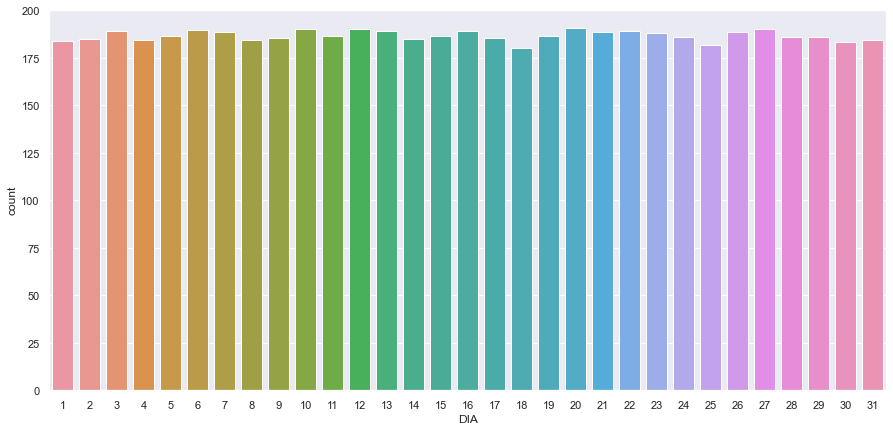

In [32]:
days = data[['DIA']].groupby(data['DIA']).agg({'count'})['DIA']
days.loc[1:28] = days.loc[1:28]/12  # En un año hay 12 días del 1 al 28
days.loc[29:30] = days.loc[29:30]/11  # En un año no bisiesto hay 11 días 29 y 30
days.loc[31] = days.loc[31]/7  # En un año hay 7 días 31
print(days)
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.barplot(x=days.index, y=days['count'], ax=ax)


Acá se ve que la distribución por día es similar también para los últimos días del mes

### 2.4.3 Días de la semana

Viernes      10292
Jueves       10250
Lunes        10131
Domingo       9796
Miercoles     9722
Martes        9662
Sabado        8352
Name: DIANOM, dtype: Int64


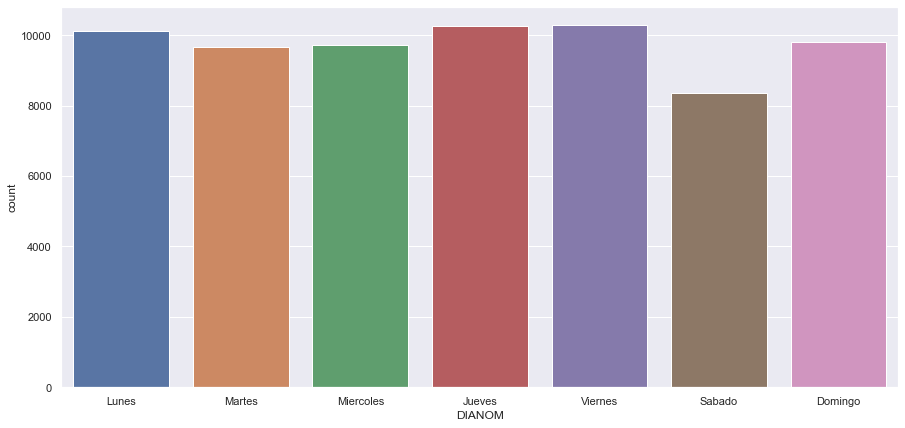

In [33]:
print(data['DIANOM'].value_counts())
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='DIANOM', ax=ax, order=['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes',
                                                                      'Sabado', 'Domingo'])

El sábado tiene notoriamente menos vuelos.

### 2.4.4 Tipo de vuelo

N    36966
I    31239
Name: TIPOVUELO, dtype: Int64


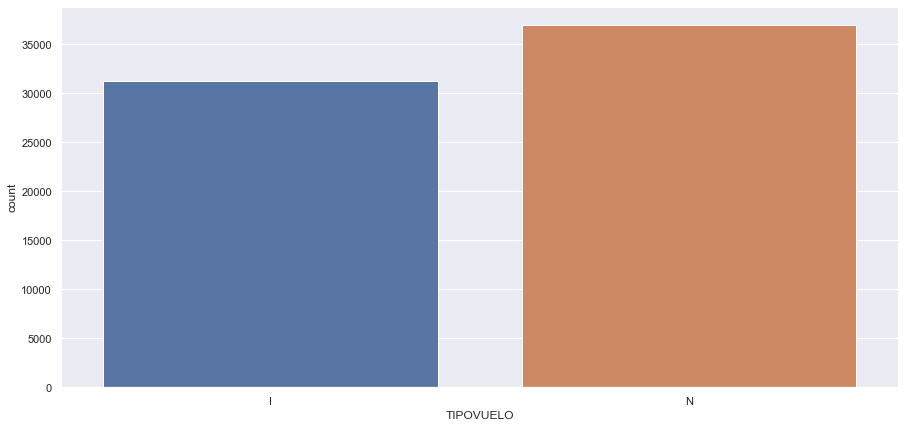

In [34]:
print(data['TIPOVUELO'].value_counts())
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
_ = sns.countplot(data=data, x='TIPOVUELO', ax=ax)

Hay más vuelos nacionales, pero ambos tipos de vuelo están dentro de los 30k-40k datos.

### 2.4.5 Aerolíneas

Grupo LATAM                 40892
Sky Airline                 14298
Aerolineas Argentinas        1949
Copa Air                     1850
Latin American Wings         1673
Avianca                      1152
JetSmart SPA                 1095
Gol Trans                     806
American Airlines             757
Air Canada                    565
Iberia                        362
Air France                    358
Delta Air                     358
Aeromexico                    351
United Airlines               335
Oceanair Linhas Aereas        279
Alitalia                      259
K.L.M.                        251
British Airways               205
Qantas Airways                195
Lacsa                          92
Aerolíneas Argentinas          74
Plus Ultra Lineas Aereas       49
Name: OPERA, dtype: Int64


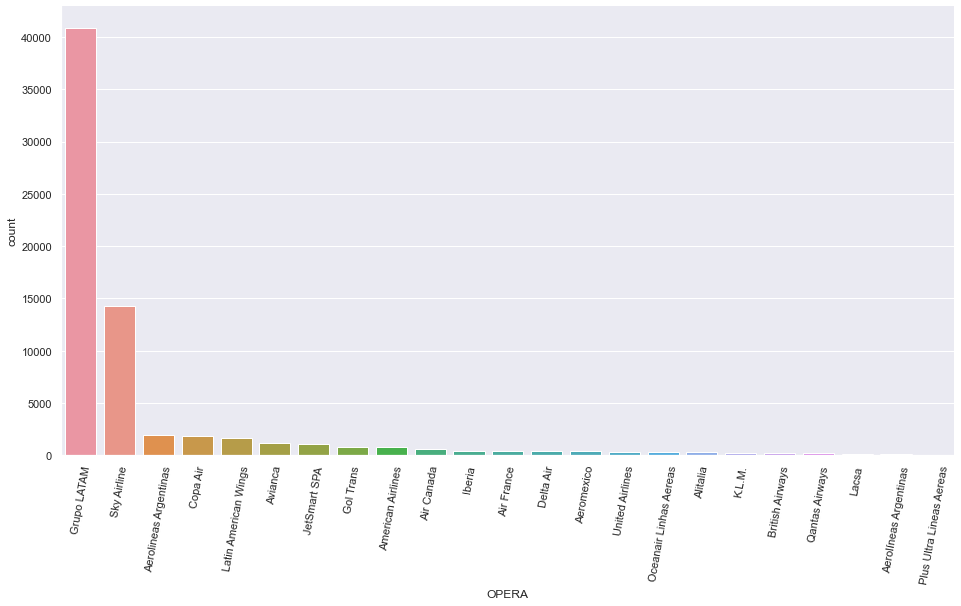

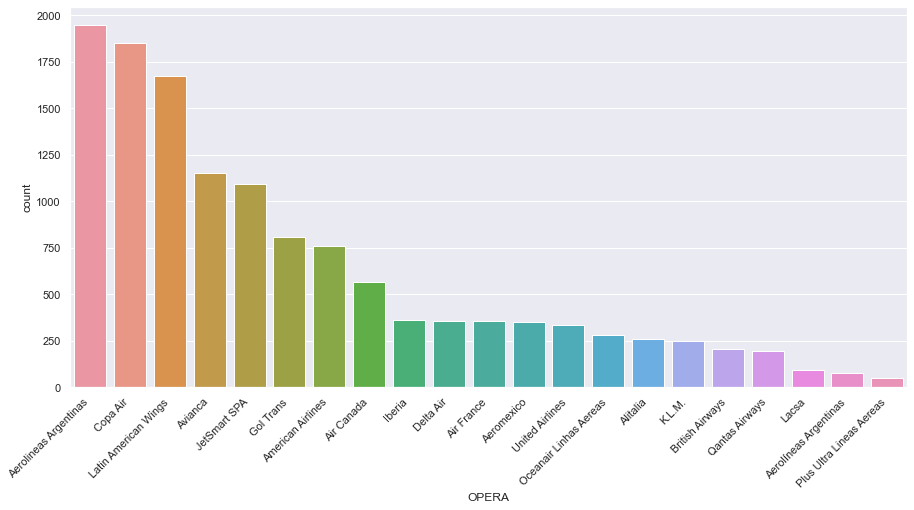

In [35]:
print(data['OPERA'].value_counts())
ax = sns.catplot(x='OPERA', kind='count', data=data, height=7, aspect=2, order = data['OPERA'].value_counts().index)

_ = ax.set_xticklabels(rotation=80)


# Second plot without the airlines with most flights
opera = data[['OPERA']].groupby(data['OPERA']).agg({'count'})['OPERA'].sort_values('count', ascending=False).iloc[2:]
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.barplot(x=opera.index, y=opera['count'], ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

Las principales aerolíneas son LATAM y Sky.

### 2.4.6 Destinos

Buenos Aires      6335
Antofagasta       5786
Lima              5269
Calama            5146
Puerto Montt      4357
                  ... 
Quito                2
Washington           1
Pisco, Peru          1
Puerto Stanley       1
Cochabamba           1
Name: SIGLADES, Length: 62, dtype: Int64


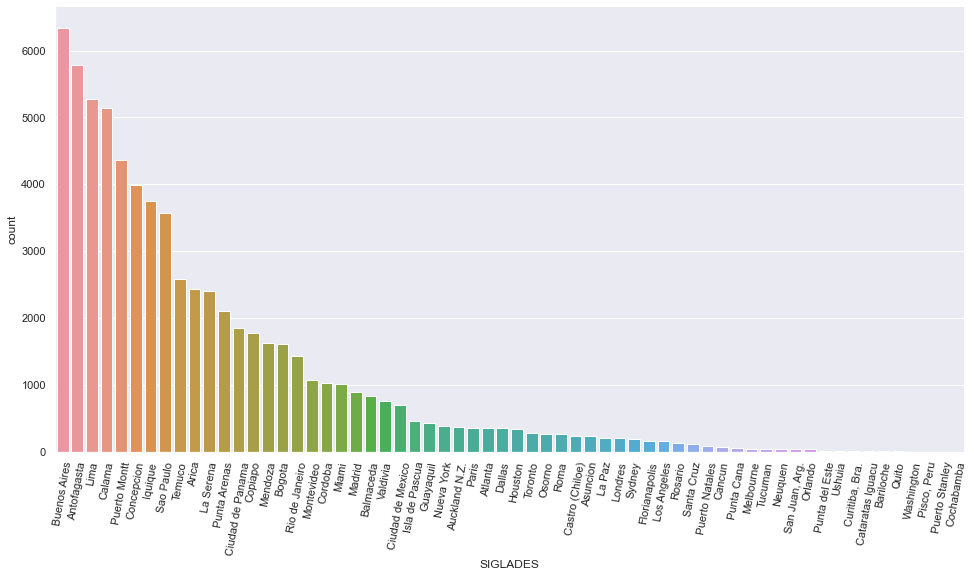

In [66]:
print(data['SIGLADES'].value_counts())
ax = sns.catplot(x='SIGLADES', kind='count', data=data, height=7, aspect=2, order = data['SIGLADES'].value_counts().index)

_ = ax.set_xticklabels(rotation=80)

La mayor cantidad de vuelos se centran en vuelos a Buenos Aires, Lima y ciudades nacionales.

In [67]:
data['lat'] = data['Des-O'].apply(get_data_by_icao, key='lat', codes=airport_codes_fix)
data['lon'] = data['Des-O'].apply(get_data_by_icao, key='lon', codes=airport_codes_fix)

In [72]:
def geoplot(data: pd.DataFrame) -> folium.Map:
    """
    Plot map with flight cities locations.
    :param df: Dataframe with geographic data (lat, lon) for each city
    :return: Folium map object
    """
    sw = data[['lat', 'lon']].min().values.tolist()
    ne = data[['lat', 'lon']].max().values.tolist()

    
    f_map = folium.Map(tiles="Stamen Terrain")
    f_map.fit_bounds([sw, ne])
    
    # cluster locations so map doesn't get cluttered
    marker_cluster = folium.plugins.MarkerCluster().add_to(f_map)

    # draw each station
    for i, row in data.iterrows():
        iframe = folium.IFrame(f"Airport: {row['name_o']}, City: {row['city_o']}")
        popup = folium.Popup(iframe, min_width=200, max_width=300)
        folium.Marker([row['lat'], row['lon']],
                      popup=popup,
                      icon=folium.Icon(icon='circle',
                                       prefix='fa')).add_to(marker_cluster)
    return f_map


df = data[['name_o', 'city_o', 'lat', 'lon']].drop_duplicates('city_o')

geoplot(data=df)

Los destinos se encuentran en Sudamérica, Norteamérica, Europa y Oceanía, siendo estos últimos 3 los menos frecuentados.